In [1]:
#Importing packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.decomposition import PCA

In [2]:
customers = pd.read_csv("Customers.csv")
transactions = pd.read_csv("Transactions.csv")

In [3]:
print(customers.columns)
print(transactions.columns)

Index(['CustomerID', 'CustomerName', 'Region', 'SignupDate'], dtype='object')
Index(['TransactionID', 'CustomerID', 'ProductID', 'TransactionDate',
       'Quantity', 'TotalValue', 'Price'],
      dtype='object')


##Data Preprocessing

In [4]:
# CustomerID is the common Unique column to merge the data
data = pd.merge(customers, transactions, on='CustomerID')

In [5]:
print(data.columns)

Index(['CustomerID', 'CustomerName', 'Region', 'SignupDate', 'TransactionID',
       'ProductID', 'TransactionDate', 'Quantity', 'TotalValue', 'Price'],
      dtype='object')


In [6]:
# Feature Engineering to find total_spent,transaction_count,average_spent
data['total_spent'] = data.groupby('CustomerID')['TotalValue'].transform('sum')
data['transaction_count'] = data.groupby('CustomerID')['TotalValue'].transform('count')
data['average_spent'] = data['total_spent'] / data['transaction_count']

In [7]:
# Remove duplicates from customers after aggregating transaction data
data = data.drop_duplicates(subset=['CustomerID'])

In [8]:
# features for clustering
X = data[['total_spent', 'transaction_count', 'average_spent']]

In [9]:
# Normalize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [10]:
# K-Means Clustering
inertia = []
silhouette_scores = []
db_indexes = []

In [11]:
# Finding the optimal number of clusters (Elbow Method)
for n_clusters in range(2, 11):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(X_scaled)

    # Calculate clustering metrics
    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_scaled, kmeans.labels_))
    db_indexes.append(davies_bouldin_score(X_scaled, kmeans.labels_))


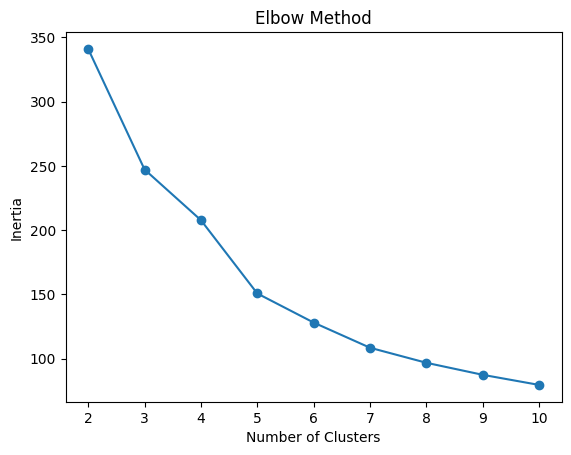

In [12]:
# Plot Elbow Method (Inertia)
plt.plot(range(2, 11), inertia, marker='o')
plt.title("Elbow Method")
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia")
plt.show()

In [13]:
optimal_clusters = 3

In [14]:
# Perform K-Means with the optimal number of clusters
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
kmeans.fit(X_scaled)

KMeans(n_clusters=3, random_state=42)

In [15]:
# Add cluster labels to the data
data['Cluster'] = kmeans.labels_

In [16]:
# Visualize clusters using PCA for 2D plotting
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

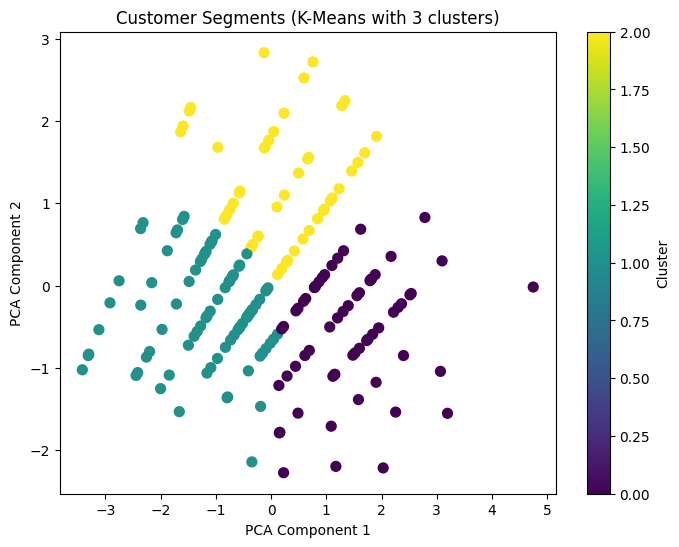

In [17]:
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=data['Cluster'], cmap='viridis', s=50)
plt.title(f'Customer Segments (K-Means with {optimal_clusters} clusters)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Cluster')
plt.show()

<Figure size 1000x800 with 0 Axes>

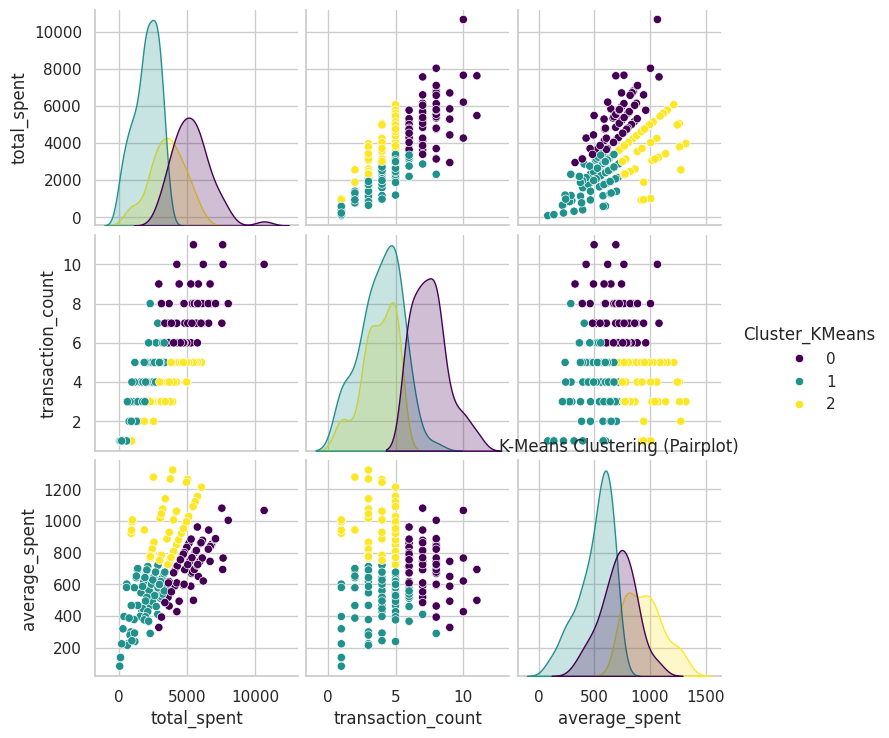

In [18]:
# Pairplot
import seaborn as sns
sns.set(style="whitegrid")
plt.figure(figsize=(10, 8))
data['Cluster_KMeans'] = kmeans.labels_
sns.pairplot(data[['total_spent', 'transaction_count', 'average_spent', 'Cluster_KMeans']], hue='Cluster_KMeans', palette='viridis')
plt.title('K-Means Clustering (Pairplot)')
plt.show()

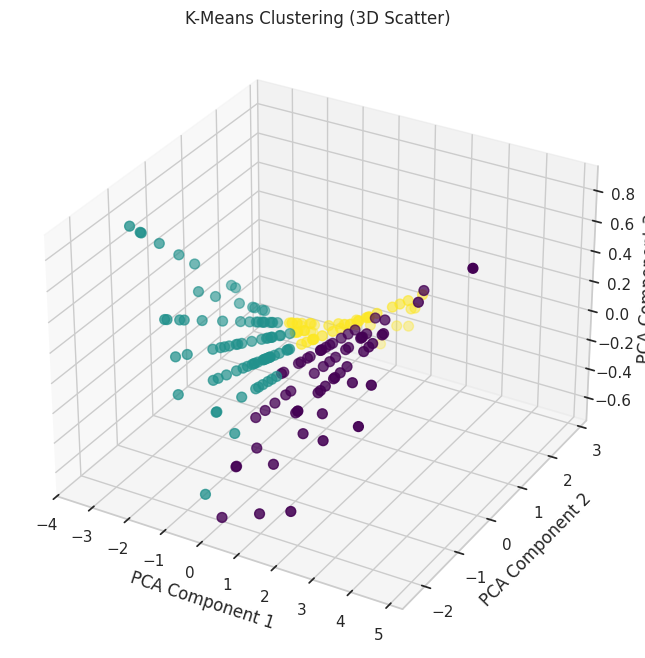

In [19]:
from mpl_toolkits.mplot3d import Axes3D

# Apply PCA for 3 components
pca_3d = PCA(n_components=3)
X_pca_3d = pca_3d.fit_transform(X_scaled)

# Visualize clusters in 3D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# K-Means 3D Scatter Plot
ax.scatter(X_pca_3d[:, 0], X_pca_3d[:, 1], X_pca_3d[:, 2], c=data['Cluster_KMeans'], cmap='viridis', s=50)
ax.set_title('K-Means Clustering (3D Scatter)')
ax.set_xlabel('PCA Component 1')
ax.set_ylabel('PCA Component 2')
ax.set_zlabel('PCA Component 3')
plt.show()

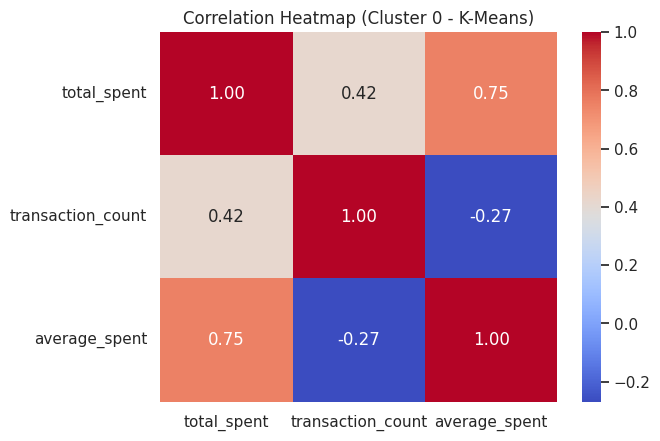

In [20]:
# Heatmap of the features
clustered_data = data[data['Cluster_KMeans'] == 0]  # Example for Cluster 0
sns.heatmap(clustered_data[['total_spent', 'transaction_count', 'average_spent']].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap (Cluster 0 - K-Means)')
plt.show()


In [21]:
# Evaluate clustering quality
print(f"Silhouette Score: {silhouette_score(X_scaled, kmeans.labels_)}")
print(f"Davies-Bouldin Index: {davies_bouldin_score(X_scaled, kmeans.labels_)}")

Silhouette Score: 0.36027262783851616
Davies-Bouldin Index: 0.9578205962311453


##Lets check with Other Clustering Models other than K-Means
##1. DBSCAN

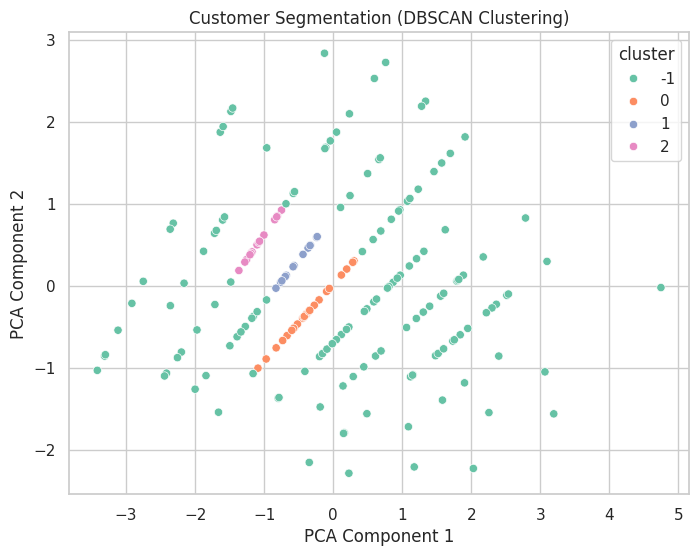

Davies-Bouldin Index: 2.7372563051930765
Silhouette Score: -0.1169722459165334
Number of Clusters (excluding noise): 4


In [22]:
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
import seaborn as sns
dbscan = DBSCAN(eps=0.5, min_samples=12)
data['cluster'] = dbscan.fit_predict(X_scaled)

# DB Index
db_index = davies_bouldin_score(X_scaled, data['cluster'])

# Silhouette Score (only applicable if all data points are assigned to clusters)
silhouette_avg = silhouette_score(X_scaled, data['cluster']) if len(set(data['cluster'])) > 1 else None

# Visualize clusters (PCA for 2D plot)
pca = PCA(n_components=2)
pca_components = pca.fit_transform(X_scaled)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=pca_components[:, 0], y=pca_components[:, 1], hue=data['cluster'], palette='Set2', legend='full')
plt.title('Customer Segmentation (DBSCAN Clustering)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()

# Output Results
print(f'Davies-Bouldin Index: {db_index}')
if silhouette_avg:
    print(f'Silhouette Score: {silhouette_avg}')
else:
    print("Silhouette Score: Cannot be computed due to only one cluster being formed.")


# Number of clusters formed (excluding noise points)
num_clusters = len(set(data['cluster'])) - (1 if -1 in data['cluster'] else 0)
print(f'Number of Clusters (excluding noise): {num_clusters}')


##2.Agglomerative **Clustering**

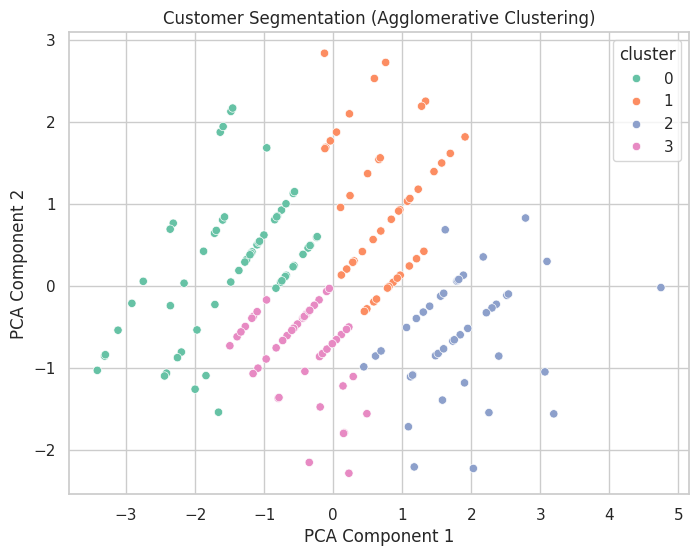

Davies-Bouldin Index: 1.0659826336687475
Silhouette Score: 0.30237684809943505
Number of Clusters: 4


In [23]:
from sklearn.cluster import AgglomerativeClustering
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.metrics import davies_bouldin_score, silhouette_score

# Apply Agglomerative Clustering
agg_clust = AgglomerativeClustering(n_clusters=4)
data['cluster'] = agg_clust.fit_predict(X_scaled)

# DB Index
db_index = davies_bouldin_score(X_scaled, data['cluster'])

# Silhouette Score (only applicable if more than 1 cluster is formed)
silhouette_avg = silhouette_score(X_scaled, data['cluster']) if len(set(data['cluster'])) > 1 else None

# Visualize clusters (PCA for 2D plot)
pca = PCA(n_components=2)
pca_components = pca.fit_transform(X_scaled)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=pca_components[:, 0], y=pca_components[:, 1], hue=data['cluster'], palette='Set2', legend='full')
plt.title('Customer Segmentation (Agglomerative Clustering)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()

# Output Results
print(f'Davies-Bouldin Index: {db_index}')
if silhouette_avg:
    print(f'Silhouette Score: {silhouette_avg}')
else:
    print("Silhouette Score: Cannot be computed due to only one cluster being formed.")

#  Summary
num_clusters = len(set(data['cluster']))  # Number of clusters
print(f'Number of Clusters: {num_clusters}')
